In [4]:
!export HF_HOME=/run/media/anton/hdd/hf

In [5]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import numpy as np
import matplotlib.pyplot as plt



os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
from diffusers import DDPMPipeline

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_generated_image.png")

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
ddpm

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.29.1",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [8]:
ddpm.unet

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [10]:
ddpm.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_large"
}

## feeding sample

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

dataset_train = datasets.CIFAR10("data", train=True, download=True,
                                     transform=transforms.Compose([transforms.ToTensor()]))
training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)

image, y = next(iter(training_data_loader))
t = 3

image = image.to(device)

Files already downloaded and verified


torch.Tensor

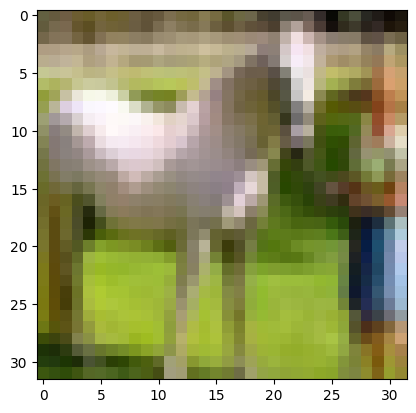

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

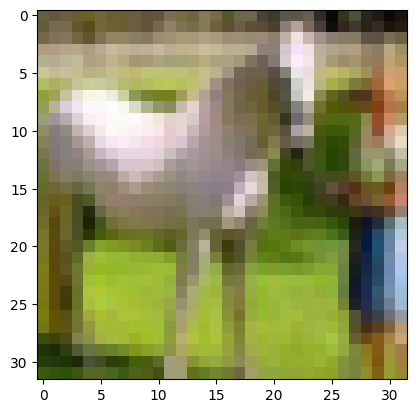

In [100]:
def add_noise(image, t, beta_start=1e-4, beta_end=2e-2, steps=1000, rescaled=False, return_beta=False):
    
    betas = torch.arange(start=beta_start, end=beta_end, step=(beta_end - beta_start)/steps)
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, dim=0).to(device)

    noise = torch.randn(image.shape).to(device)

    image_scaled = 2 * image - 1

    image_noisy = torch.sqrt(alphas_prod[t]) * image_scaled + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)

    if return_beta:
        return image_noisy, betas[t]
    
    return image_noisy


image_noisy = add_noise(image=image, t=t, rescaled=True)

plt.imshow(np.moveaxis(image_noisy[0].cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8805158..1.6607609].


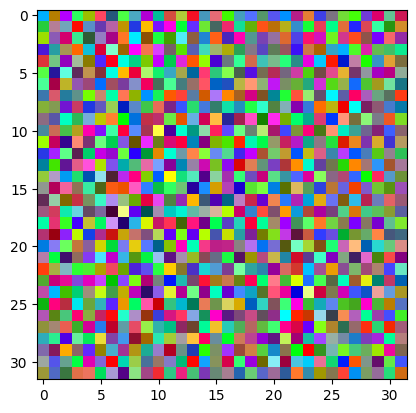

In [20]:
image_noisy = add_noise(image=image, t=t, rescaled=False)
image_dn = ddpm.unet(image_noisy, t).sample / 2 + 0.5
plt.imshow(np.moveaxis(image_dn[0].detach().cpu().numpy(), 0, -1))

## TODO: figure out exactly how to delete noise from noisy image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3016087..1.5291399].


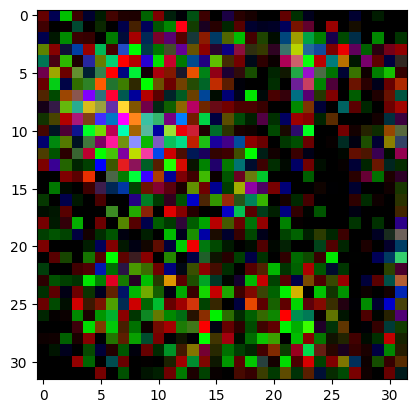

In [24]:
plt.imshow(np.moveaxis((torch.clip(image_noisy / 2 + 0.5, min=0, max=1)[0] - image_dn[0]).detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8805158..1.6607609].


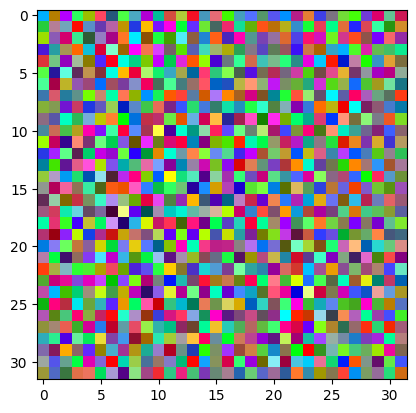

In [26]:
def evaluate_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    out = ddpm.unet(x, t).sample
    return torch.reshape(out, (3072,))

img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

noise_v = evaluate_as_vector(img_noisy_v)

plt.imshow(np.moveaxis(torch.reshape(noise_v / 2 + 0.5, (1,3,32,32))[0].detach().cpu().numpy(), 0, -1))

In [27]:
from torch.autograd.functional import jacobian

J_trained = jacobian(evaluate_as_vector, inputs=img_noisy_v)

In [28]:
eig = torch.linalg.eig(J_trained)
svd = torch.svd(J_trained)

/home/anton/source/torch-env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/anton/source/torch-env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


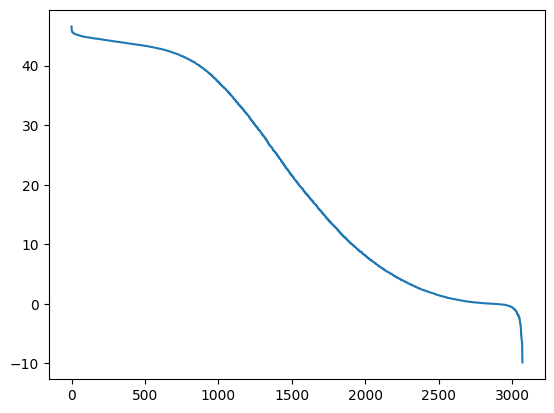

In [29]:
plt.plot(sorted(eig.eigenvalues.detach().cpu().numpy(), reverse=True))

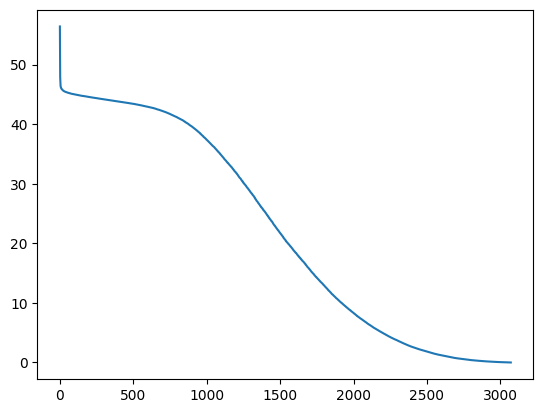

In [30]:
sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
plt.plot(sv_sorted)

### put it in a loop



In [69]:
#CURR_OUT = dict(zip(range(1, 1000, 50), sv_out))
CURR_OUT

{1: [tensor(82.9777),
  tensor(74.2767),
  tensor(72.3605),
  tensor(71.3924),
  tensor(70.9406),
  tensor(70.2917),
  tensor(70.0279),
  tensor(69.9237),
  tensor(69.8233),
  tensor(69.7422),
  tensor(69.6618),
  tensor(69.6138),
  tensor(69.5082),
  tensor(69.4533),
  tensor(69.4079),
  tensor(69.3685),
  tensor(69.2816),
  tensor(69.2474),
  tensor(69.2358),
  tensor(69.2044),
  tensor(69.1800),
  tensor(69.1308),
  tensor(69.1096),
  tensor(69.0915),
  tensor(69.0373),
  tensor(69.0256),
  tensor(68.9690),
  tensor(68.9190),
  tensor(68.8755),
  tensor(68.8728),
  tensor(68.8475),
  tensor(68.8197),
  tensor(68.7814),
  tensor(68.7693),
  tensor(68.7390),
  tensor(68.7125),
  tensor(68.6787),
  tensor(68.6767),
  tensor(68.6679),
  tensor(68.6390),
  tensor(68.6203),
  tensor(68.6108),
  tensor(68.6012),
  tensor(68.5759),
  tensor(68.5599),
  tensor(68.5333),
  tensor(68.5211),
  tensor(68.5034),
  tensor(68.4799),
  tensor(68.4760),
  tensor(68.4627),
  tensor(68.4581),
  tensor(

In [70]:
# sv_out = []
sv_out_new = []

for t in range(1, 50, 3):
    image_noisy = add_noise(image, t)
    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    def evaluate_as_vector(x):
        x = torch.reshape(x, (1,3,32,32))
        out = ddpm.unet(x, t).sample
        print(t)
        return torch.reshape(out, (3072,))

    J_trained = jacobian(evaluate_as_vector, inputs=img_noisy_v)
    
    svd = torch.svd(J_trained)
    sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
    # sv_out.append(sv_sorted)
    sv_out_new.append(sv_sorted)

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49


In [71]:
NEW_OUT = dict(zip(range(1, 50, 3), sv_out_new))

In [74]:
CURR_OUT.update(NEW_OUT)

CURR_OUT.keys()

dict_keys([1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])

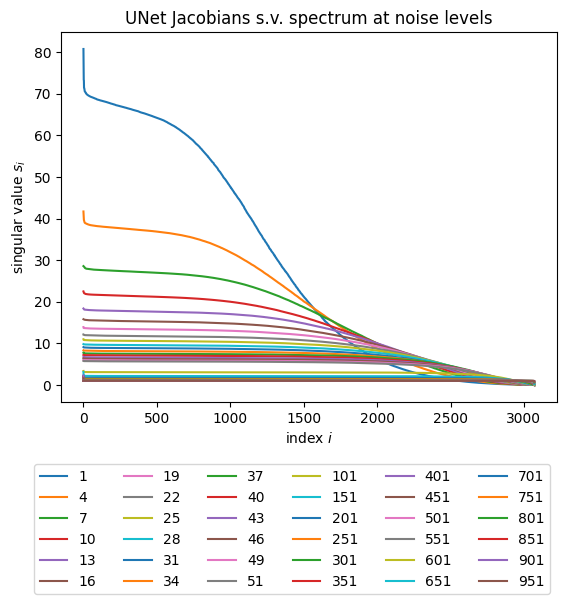

In [89]:
times = sorted(CURR_OUT.keys())

for t in times:
    # if t > 1: plt.plot(CURR_OUT[t], label=t)
    plt.plot(CURR_OUT[t], label=t)
    # plt.plot(sv, label=t)
plt.title("UNet Jacobians s.v. spectrum at noise levels")
plt.ylabel("singular value $s_i$")
plt.xlabel("index $i$")
plt.legend(bbox_to_anchor=(1, -0.15), ncols=6)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951]
[tensor(26.6711), tensor(32.1855), tensor(36.6513), tensor(38.0051), tensor(40.2681), tensor(41.4024), tensor(42.1158), tensor(43.2168), tensor(43.7326), tensor(44.8838), tensor(44.8648), tensor(45.5555), tensor(45.9367), tensor(46.7936), tensor(46.9134), tensor(47.3682), tensor(47.8222), tensor(47.7832), tensor(47.2120), tensor(36.1750), tensor(41.5346), tensor(40.2731), tensor(35.5241), tensor(32.9425), tensor(26.5229), tensor(36.5492), tensor(54.7024), tensor(54.7627), tensor(54.7948), tensor(54.7342), tensor(54.7465), tensor(54.6355), tensor(54.7070), tensor(54.4069), tensor(53.6758), tensor(53.7998)]


Text(0.5, 0, 'noise level')

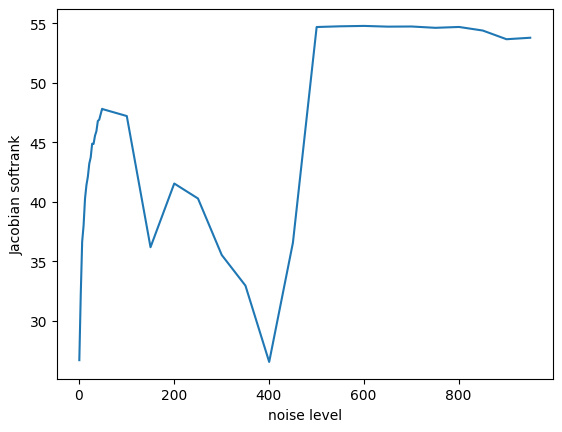

In [91]:
def softrank(sv):
    sv_sorted = sorted(sv, reverse=True)
    return torch.norm(torch.stack(sv_sorted)) / sv_sorted[0]

print(times)
softranks = [softrank(CURR_OUT[t]) for t in times]
print(softranks)
plt.plot(times, softranks)
plt.ylabel("Jacobian softrank")
plt.xlabel("noise level")

Text(0.5, 0, 'noise level')

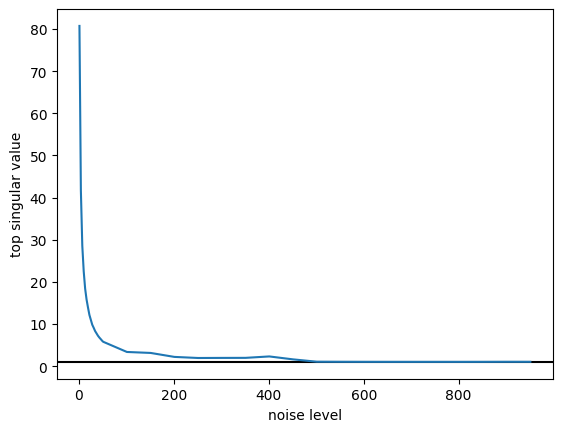

In [97]:
top = [CURR_OUT[t][0] for t in times]
plt.axhline(1, color="black")
plt.plot(times, top)

plt.ylabel("top singular value")
plt.xlabel("noise level")

In [101]:
sv_cov = {}
J_trace = {}

for t in times:
    image_noisy, beta_t = add_noise(image, t, return_beta=True)
    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    def evaluate_as_vector(x):
        x = torch.reshape(x, (1,3,32,32))
        out = ddpm.unet(x, t).sample
        print(t)
        return torch.reshape(out, (3072,))

    J_trained = jacobian(evaluate_as_vector, inputs=img_noisy_v)

    J_trace[t] = torch.trace(J_trained)

    J_trained *= beta_t
    
    svd = torch.svd(J_trained)
    sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
    # sv_out.append(sv_sorted)
    sv_cov[t] = sv_sorted

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
951


Text(0, 0.5, 'UNet Jacobians trace at different noise levels')

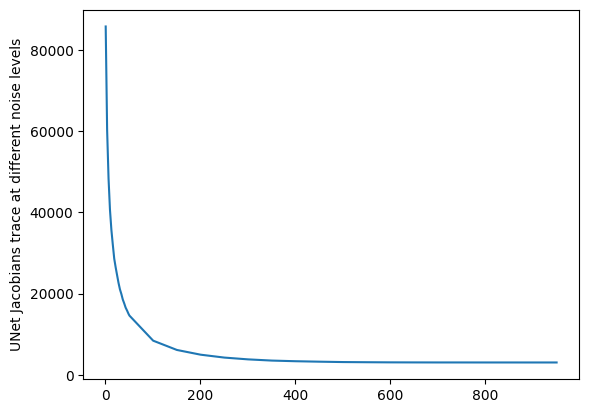

In [111]:
traces = [x.detach().cpu().numpy() for x in J_trace.values()]
plt.plot(times, traces)
plt.ylabel("trace")
plt.ylabel("noise level")
plt.ylabel("UNet Jacobians trace at different noise levels")

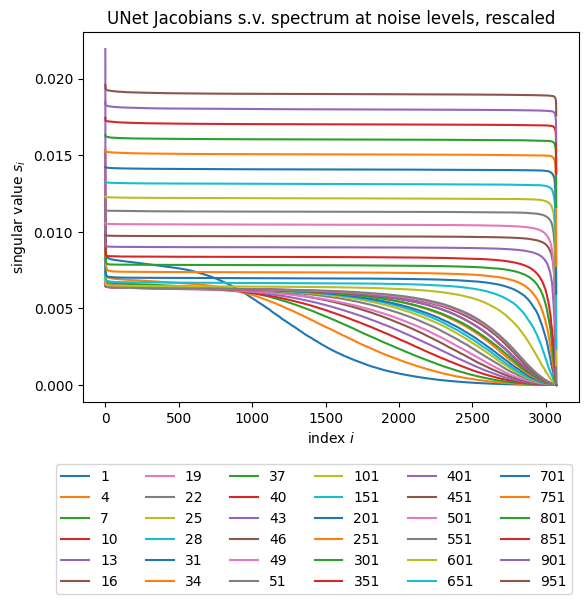

In [110]:
for t in times:
    # if t > 1: plt.plot(CURR_OUT[t], label=t)
    plt.plot(sv_cov[t], label=t)
    # plt.plot(sv, label=t)
plt.title("UNet Jacobians s.v. spectrum at noise levels, rescaled")
plt.ylabel("singular value $s_i$")
plt.xlabel("index $i$")
plt.legend(bbox_to_anchor=(1, -0.15), ncols=6)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951]
[tensor(26.3439), tensor(28.4999), tensor(34.0330), tensor(37.9462), tensor(39.6209), tensor(41.4002), tensor(42.2604), tensor(43.2268), tensor(44.2478), tensor(44.9803), tensor(44.8081), tensor(45.8871), tensor(45.5847), tensor(46.0010), tensor(46.7613), tensor(47.0682), tensor(46.7939), tensor(47.9819), tensor(48.5025), tensor(42.4016), tensor(37.3224), tensor(42.4143), tensor(35.2876), tensor(29.6091), tensor(22.5192), tensor(54.6764), tensor(54.5977), tensor(54.8429), tensor(54.7854), tensor(54.7811), tensor(54.7997), tensor(54.3470), tensor(54.3773), tensor(54.1189), tensor(53.9428), tensor(53.7488)]


Text(0.5, 0, 'noise level')

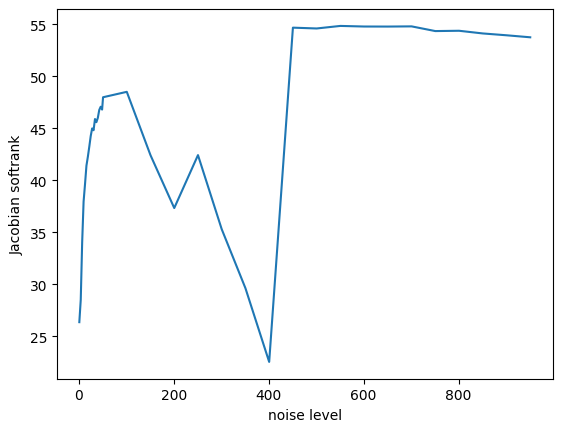

In [109]:
print(times)
softranks_cov = [softrank(sv_cov[t]) for t in times]
print(softranks_cov)
plt.plot(times, softranks_cov)
plt.ylabel("Jacobian softrank")
plt.xlabel("noise level")